# EEG Preprocessing

### Experiment
In the experiment, checkerboard patterns were presented to the subject into the left and right visual field, interspersed by tones to the left or right ear. The interval between the stimuli was 750 ms. Occasionally a smiley face was presented at the center of the visual field. The subject was asked to press a key with the right index finger as soon as possible after the appearance of the face.

## Loading modules & data

In [1]:
# importing modules
import os
import numpy as np
import mne

In [2]:
# reading the file & loading in the data
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.info['bads'] = []

raw.load_data()

Opening raw data file C:\Users\sarak\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


<Raw | sample_audvis_raw.fif, 376 x 166800 (277.7 s), ~481.8 MB, data loaded>

Looking at the ouput from the load.data() function, try to figure out:

- How many EEG channels?
- Do you see any EEG channels marked as bad during recording?
- What is the sampling frequency?
- How many minutes of data were recorded?

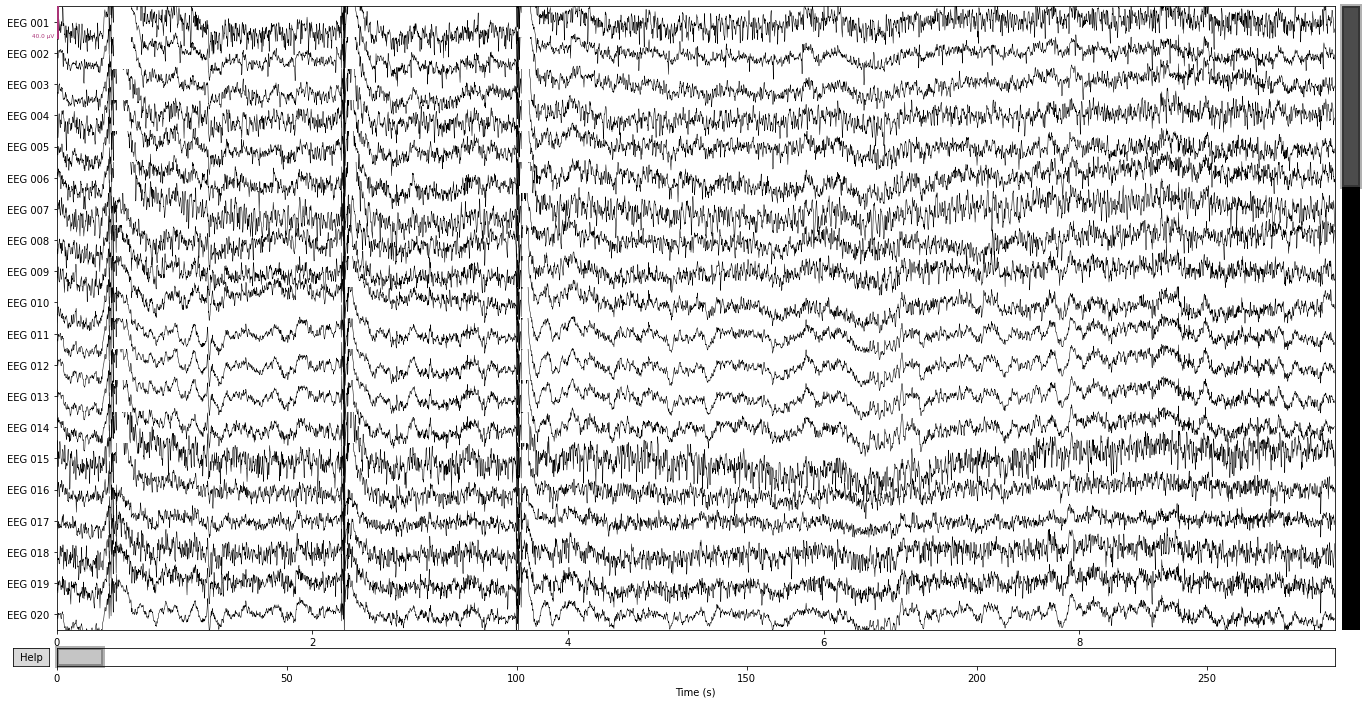

AttributeError: 'MNEBrowseFigure' object has no attribute 'title'

In [6]:
# selecting only EEG and stimulus data & plotting raw data
raw.pick_types(meg=False, eeg=True, stim=True, exclude=[])
plot = raw.plot();
plot.title("Title")

Right now we are plotting using the default argument values of the plot() function. Try to play around with the function in order to:

- Plot all EEG channels simultaneously
- Plot a full minute of the recording
- Give the plot a fitting title

Hint: if you are in VS Code, you can see what the arguments of a function are by hovering over the function with your cursor.

## Excluding bad channels
When plotting all 60 channels, you should be able to see that one channel seems bad (i.e. it is pretty flat). We want to mark it is bad in our data.

In [ ]:
# input the name of the bad EEG channel here, e.g. ['EEG 002']
raw.info['bads'] = []
raw.plot(n_channels=60);

Now that we have marked the channel as bad, we can exclude it. 

In [ ]:
# now we can exclude any channels in the 'bad channels' variable
raw.pick_types(meg=False, eeg=True, stim=True, exclude='bads')
raw.plot(n_channels=60);

Now it's gone! Let's move on to filtering the data in order to enhance the signal.

## Filtering
We high-pass filter the data at 0.1 Hz and low-pass filter the data at 40 Hz, following the typical practices of EEG preprocessing. The high-pass filter minimises slow drifts in the data (e.g. scalp potentials), while the low-pass filter excludes high-frequency noise (e.g. line noise (50 Hz) or EMG (muscle-related artefacts)), with frequencies higher than the frequencies of the signal we are interested in.

In [ ]:
# high-pass filtering the data at 0.1 Hz and subsequently low-pass filtering at 40 Hz
raw = raw.filter(0.1, None)
raw = raw.filter(None, 40)

# plotting the filtered data for inspection
raw.plot();

Compare the filtered signal to the raw signal you plotted in the beginning. Does it look cleaner?

## Artefact detection
There are many ways to detect and deal with artefacts. Today, we simply select a value and reject anything above or below that value. We do this because we determine that values over or under this threshold are liekly not related to brain activity. For now, we just create the variable and then we use it to remove artefacts while epoching.

In [ ]:
# rejecting everything over or under a threshold of 150 microvolts
# anything above or belove this threshold is likely not brain activity but artefacts
reject = dict(eeg=150e-6)

## Epoching
We now want to create epochs according to the events in our data, e.g. stimuli presentation. So first, we locate the events!

In [ ]:
# this function locates any stimulus events in the recording (e.g. presentation of stimuli or button presses)
events = mne.find_events(raw)

In [ ]:
# we can make a dictionary of what the event IDs represent
# by using '/' we can actually later index one dimension *across* the other, i.e. if we just write 'left' we get all events presented to the left side, both auditory and visual
event_id = {'auditory/left': 1,
              'auditory/right': 2,
              'visual/left': 3,
              'visual/right': 4,
              'smiley': 5,
              'button': 32
              }

In [ ]:
# plotting the events
mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);


The time window we establish span from 0.2 seconds before stimulus onset to 0.5 seconds after stimulus onset. The 200 milliseconds before the onset of the stimulus enables us to examine a baseline of activity without stimulus presentation. The 500 milliseconds after the stimulus onset denote the time in which we expect the effect to occur, since most EEG components arise before the 500 milliseconds mark.

In [ ]:
# establishing time window
tmin, tmax = -0.2, 0.5

# choosing only EEG channels for epoching
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False)

In [ ]:
# creating the epochs using the variables created in the cell above, and timelocking to the events
# baseline time interval spans from beginning of the data (-0.2 s) to 0 s (stimulus onset)
# we use the reject variable we created earlier in order to remove artefacts
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)

As you can see, we are dropping some epochs that were deeemed 'bad' because they contain values over or under the threshold we defined, allowing us to exclude epochs with artefacts.

## Downsampling
Now we reduce the sample-rate to 250 Hz instead of 600. We do this after epoching, since downsampling before epoching can potentially mess with the precision of the extraction of epochs.

In [ ]:
# downsampling to 250 Hz
epochs_resampled = epochs.resample(250)

## ERPs
Now we can group the epochs by modality (auditory/visual) and take a look at the differences between them!

In [ ]:
# now the '/' used in the event IDs comes in handy! To get all epochs with auditory stimuli, we can index 'auditory' across the left/right dimension (and 'visual', of course)
# that way we don't have to specify 'auditory_left' and 'auditory_right' etc.
aud_epochs = epochs_resampled['auditory']
vis_epochs = epochs_resampled['visual']

# plotting one channel as an example for each modality
aud_epochs.plot_image(picks=['EEG 021']);
vis_epochs.plot_image(picks=['EEG 021']);

These plots show each epoch as one row of the image map for the chosen channel, with color representing signal magnitude. The average evoked response and the sensor location are shown below the image. This gives us an idea of whether there is consistency in the signal.

In your view, which is the most consistent signal of the two? Why do you think that is?

(hint 1: where is the EEG 021 channel located on the scalp?)

(hint 2: maybe try using plot_sensors and flagging show_names=True)

Which channel would you choose if you were to reverse the pattern of the signal consistencies? Go ahead and try it out...

In [ ]:
# creating evokeds for auditory condition by averaging over epochs
aud_evoked = aud_epochs.average()

# creating evokeds for visual condition
vis_evoked = vis_epochs.average()

In [ ]:
# plotting the two evokeds together
mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked),
                             legend='upper left', show_sensors='upper right')

Looking a bit closer at the averaged responses, here visualized with the gfp (global field power).

GFP is actually the same as taking the standard deviation across all channels in each time sample. This tells us in which timepoints we see the biggest difference between different channels, which in turn is indicative of some kind of (more or less) focal activity. Quite neat actually.

Looking at the plot, where in time do you see the strongest response in the auditory and visual conditions, respectively?

Do those timepoints match any well-known components relevant in this context? 

(hint: N100 and N170)

Now compare with the "joint" plots below - do those plots match your observations from the GFP-plots?

In [ ]:
aud_evoked.plot_joint(picks='eeg');

In [ ]:
vis_evoked.plot_joint(picks='eeg');

As a final note, we can create contrasts (aka. difference waves) on the fly by using the combine_evoked-function (in combination with the weights=[1, -1]-parameter).

This also gives us a chance to try out one final plotting function, namely the plot_topo-function. This function plots the difference waves (or whichever traces we choose to plot) for each channel in their positions on the scalp.

In [ ]:
evoked_diff = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])
evoked_diff.pick_types(eeg=True).plot_topo(color='r', legend=False)

# Optional/bonus
## Independent component analysis (ICA)
ICA can be used for artefact detection, since it identifies seperate components of the signal that have been combined during recording. That means that we can actually separate noise compoenents, such as eye blinks, from the rest of the signal, and thereby exclude them.

In [ ]:
# set up and fit the ica with 800 iterations with a random seed at 97
# n_components=0.95 ensures that the number of components selected explain at least 95% of the variance in the data
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(raw)

In [ ]:
# plotting the ica components
ica.plot_components();

In [ ]:
# plotting the time series of the ica
ica.plot_sources(raw, show_scrollbars=False);

From visual inspection of the topographic maps and the time series plots of the components, we can see that the first component seems to capture noise. Consequently, we can remove it and thereby extract these artefacts from the data.

In [ ]:
# the first component is excluded based on visual inspection
ica.exclude = [0]
ica.plot_properties(raw, picks=ica.exclude);

We can now apply the ICA to the data.

In [ ]:
# applying the ica to the data
ica.apply(raw)

In [ ]:
# plotting the data after filtering and ica
raw.plot();

Now try to run 
- artefact-detection
- epoching
- downsampling
- the single-trial plots
- the evokeds plots

(i.e. exactly like you just did in the above)

Now compare your results with and without ICA - can you tell any differences between the two, just qualitatively speaking?